In [1]:
# user_id:用户ID，order_dt:购买日期，order_products:购买产品数量,order_amount:购买金额
# 数据时间：1997年1月~1998年6月用户行为数据，约6万条

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline
plt.style.use('ggplot')  #更改绘图风格，R语言绘图库的风格
plt.rcParams['font.sans-serif'] = ['SimHei']

In [2]:
# 导入数据
columns = ['user_id','order_dt','order_products','order_amount']
df = pd.read_table('CDNOW_master.txt',names=columns,sep='\s+')  #sep:'\s+':匹配任意个空格
df.head()
#1.日期格式需要转换
#2.存在同一个用户一天内购买多次行为

,user_id,order_dt,order_products,order_amount
0,1,19970101,1,11.77
1,2,19970112,1,12.00
2,2,19970112,5,77.00
3,3,19970102,2,20.76
4,3,19970330,2,20.76


In [3]:
df.describe()
#1.用户平均每笔订单购买2.4个商品，标准差2.3，稍微有点波动，属于正常。
#然而75%分位数的时候，说明绝大多数订单的购买量都不多，围绕在2~3个产品左右；
#2.购买金额，反映出大部分订单消费金额集中在中小额，30~45左右

,user_id,order_dt,order_products,order_amount
count,69659.000000,6.965900e+04,69659.000000,69659.000000
mean,11470.854592,1.997228e+07,2.410040,35.893648
std,6819.904848,3.837735e+03,2.333924,36.281942
min,1.000000,1.997010e+07,1.000000,0.000000
25%,5506.000000,1.997022e+07,1.000000,14.490000
50%,11410.000000,1.997042e+07,2.000000,25.980000
75%,17273.000000,1.997111e+07,3.000000,43.700000
max,23570.000000,1.998063e+07,99.000000,1286.010000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69659 entries, 0 to 69658
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   user_id         69659 non-null  int64  
 1   order_dt        69659 non-null  int64  
 2   order_products  69659 non-null  int64  
 3   order_amount    69659 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 2.1 MB


### 数据预处理

In [5]:
df['order_date'] = pd.to_datetime(df['order_dt'],format='%Y%m%d')
#format参数：按照指定的格式去匹配要转换的数据列。
#%Y:四位的年份1994   %m:两位月份05  %d:两位月份31  
#%y：两位年份94  %h:两位小时09  %M：两位分钟15    %s:两位秒 
#将order_date转化成精度为月份的数据列
df['month'] = df['order_date'].astype('datetime64[M]')  #[M] :控制转换后的精度
df.head()
# df.info()

,user_id,order_dt,order_products,order_amount,order_date,month
0,1,19970101,1,11.77,1997-01-01,1997-01-01
1,2,19970112,1,12.00,1997-01-12,1997-01-01
2,2,19970112,5,77.00,1997-01-12,1997-01-01
3,3,19970102,2,20.76,1997-01-02,1997-01-01
4,3,19970330,2,20.76,1997-03-30,1997-03-01


Text(0.5, 1.0, '每月的消费人数')

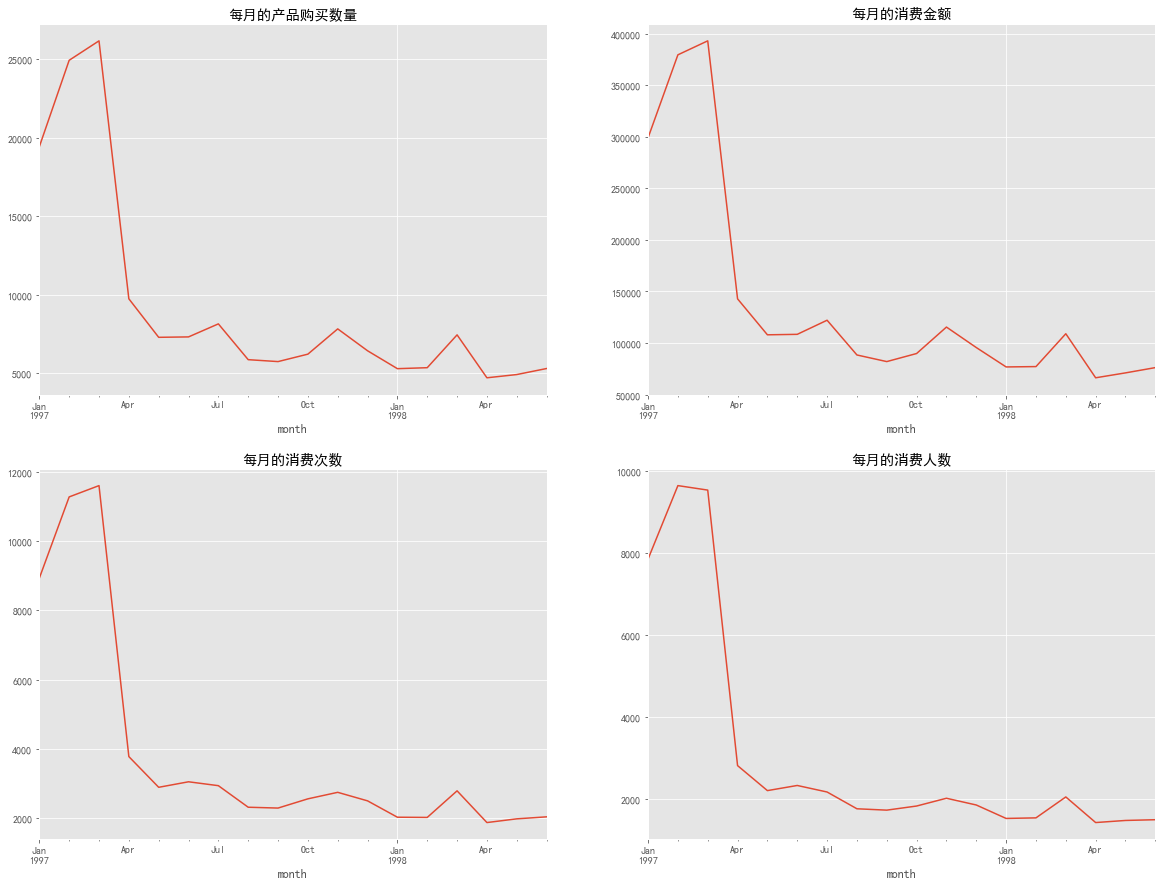

In [6]:
# 用户整体消费趋势分析（按月份）
# 按月份统计产品购买数量，消费金额，消费次数，消费人数
plt.figure(figsize=(20,15)) #单位时英寸
# 每月的产品购买数量
plt.subplot(221)  #两行两列，占据第一个位置
df.groupby(by='month')['order_products'].sum().plot()  #默认折线图
plt.title('每月的产品购买数量')
# 每月的消费金额
plt.subplot(222)  #两行两列
df.groupby(by='month')['order_amount'].sum().plot()  #默认折线图
plt.title('每月的消费金额')
# 每月的消费次数
plt.subplot(223)  #两行两列
df.groupby(by='month')['user_id'].count().plot()  #默认折线图
plt.title('每月的消费次数')
# 每月的消费人数（根据user_id进行去重统计，再计算个数）
plt.subplot(224)  #两行两列
df.groupby(by='month')['user_id'].apply(lambda x:len(x.drop_duplicates())).plot()  #默认折线图
plt.title('每月的消费人数')
#分析结果：
# 图一可以看出，前三个月销量非常高，而以后销量较为稳定，并且稍微呈现下降趋势
# 图二可以看出,依然前三个月消费金额较高，与消费数量成正比例关系，三月份过后下降严重，并呈现下降趋势，思考原因？1：跟月份有关，
# 在我国来1，2，3月份处于春节前后。2.公司在1，2，3，月份的时候是否加大了促销力度
# 图三可以看出，前三个月订单数在10000左右，后续月份的平均消费单数在2500左右
# 图四可以看出，前三个月消费人数在8000~10000左右，后续平均消费消费在2000不到的样子
# 总结：所有数据显示，97年前三月消费事态异常，后续趋于常态化

## 用户个体消费分析

### 1.用户消费金额，消费次数(产品数量)描述统计

In [7]:
user_grouped = df.groupby(by='user_id').sum()
print(user_grouped.describe())
print('用户数量:',len(user_grouped))
# 从用户的角度：用户数量23570个，每个用户平均购买7个CD，但是中位数只有3，
#  并且最大购买量为1033，平均值大于中位数，属于典型的右偏分布(替购买量<7的用户背锅)
# 从消费金额角度：平均用户消费106，中位数43，并且存在土豪用户13990，结合分位数和最大值来看，平均数与75%分位数几乎相等，
# 属于典型的右偏分布，说明存在小部分用户（后面的25%）高额消费（这些用户需要给消费金额<106的用户背锅，只有这样才能使平均数维持在106）

           order_dt  order_products  order_amount
count  2.357000e+04    23570.000000  23570.000000
mean   5.902627e+07        7.122656    106.080426
std    9.460684e+07       16.983531    240.925195
min    1.997010e+07        1.000000      0.000000
25%    1.997021e+07        1.000000     19.970000
50%    1.997032e+07        3.000000     43.395000
75%    5.992125e+07        7.000000    106.475000
max    4.334408e+09     1033.000000  13990.930000
用户数量: 23570


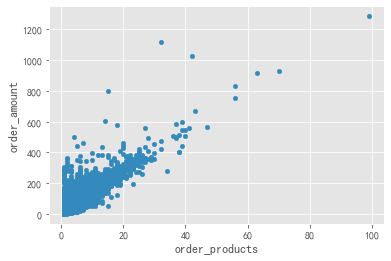

In [8]:
#绘制每个用户的产品的购买量与消费金额散点图
df.plot(kind='scatter',x='order_products',y='order_amount')
# 从图中可知，用户的消费金额与购买量呈现线性趋势，每个商品均价15左右
# 订单的极值点比较少（消费金额>1000，或者购买量大于60）,对于样本来说影响不大，可以忽略不记。

### 2.用户消费分布图

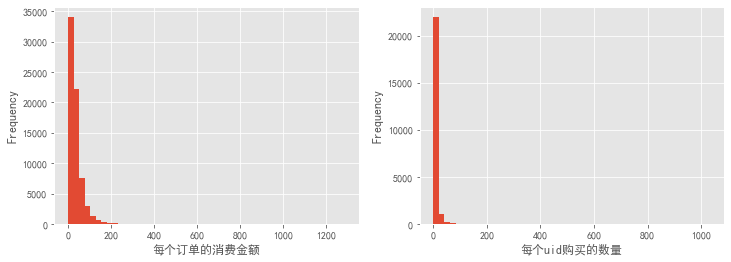

In [13]:
plt.figure(figsize=(12,4)) 
plt.subplot(121)
plt.xlabel('每个订单的消费金额')
df['order_amount'].plot(kind='hist',bins=50)  #bins:区间分数，影响柱子的宽度，值越大柱子越细。宽度=（列最大值-最小值）/bins
#消费金额在100以内的订单占据了绝大多数

plt.subplot(122)
plt.xlabel('每个uid购买的数量')
df.groupby(by='user_id')['order_products'].sum().plot(kind='hist',bins=50)
#图二可知，每个用户购买数量非常小，集中在50以内
# 两幅图得知，我们的用户主要是消费金额低，并且购买小于50的用户人数占据大多数（在电商领域是非常正常的现象）


### 3.用户累计消费金额占比分析（用户的贡献度）

In [14]:
#进行用户分组，取出消费金额，进行求和，排序，重置索引
user_cumsum = df.groupby(by='user_id')['order_amount'].sum().sort_values().reset_index()
user_cumsum

,user_id,order_amount
0,10175,0.00
1,4559,0.00
2,1948,0.00
3,925,0.00
4,10798,0.00
...,...,...
23565,7931,6497.18
23566,19339,6552.70
23567,7983,6973.07
23568,14048,8976.33


In [17]:
#每个用户消费金额累加
# 累加器举例：
# a = [1,2,3,4,5,6,7]
# print(np.cumsum(a))
user_cumsum['amount_cumsum'] = user_cumsum['order_amount'].cumsum()
user_cumsum.tail()

,user_id,order_amount,amount_cumsum
23565,7931,6497.18,2463822.60
23566,19339,6552.70,2470375.30
23567,7983,6973.07,2477348.37
23568,14048,8976.33,2486324.70
23569,7592,13990.93,2500315.63


In [19]:
amount_total = user_cumsum['amount_cumsum'].max() #消费金额总值
user_cumsum['prop'] = user_cumsum.apply(lambda x:x['amount_cumsum']/amount_total,axis=1)  #前xx名用户的总贡献率
user_cumsum.tail()

,user_id,order_amount,amount_cumsum,prop
23565,7931,6497.18,2463822.60,0.985405
23566,19339,6552.70,2470375.30,0.988025
23567,7983,6973.07,2477348.37,0.990814
23568,14048,8976.33,2486324.70,0.994404
23569,7592,13990.93,2500315.63,1.000000


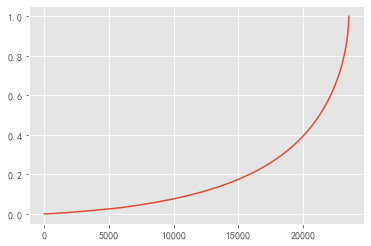

In [22]:
user_cumsum['prop'].plot()
# 由图分析可知，前20000名用户贡献总金额的40%，剩余3500名用户贡献了60%。（2/8原则）